# Treasury Yield Spread vs Asset Price Performance

Interactive visualization comparing the 10-Year minus 2-Year Treasury yield spread against 6-month percent changes in major asset classes (S&P 500, NASDAQ, Gold, Silver).

## Features

**Multi-Asset Comparison**
- S&P 500, NASDAQ, Gold, and Silver 6-month rolling returns
- 10Y-2Y Treasury yield spread overlay on secondary axis
- Toggle visibility via legend clicks

**Economic Context Overlays**
- NBER recession periods (red shading)
- Yield curve inversion periods (yellow shading) — historically a leading recession indicator

**Correlation Analysis**
- 12-month rolling correlation between NASDAQ returns and yield spread
- Absolute correlation magnitude to identify periods of strong relationship regardless of direction

**Interactive Charts**
- Unified crosshair spanning all subplots
- Hover tooltips with precise values
- Zoom and pan with synchronized axes
- Responsive layout for different screen sizes

## Data Sources
- **Equities**: Yahoo Finance (NASDAQ, S&P 500)
- **Commodities**: World Bank historical data + Yahoo Finance (Gold, Silver)
- **Treasury Yields**: FRED (Federal Reserve Economic Data)
- **Recession Indicators**: FRED (NBER recession dates)

In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import yfinance as yf
import pandas_datareader.data as web
from datetime import datetime, timedelta

from helpers import (
    load_all_data,
    get_recession_periods,
    get_inversion_periods
)

In [2]:
# Load all economic data (uses cache if available)
combined = load_all_data()

Loading data (from cache if available)...
Loaded 596 months of data (1976-06 to 2026-01)


In [3]:
# Calculate recession periods and correlation
recession_periods = get_recession_periods(combined)

overall_corr = combined['NASDAQ 6M %'].corr(combined['Yield Spread'])
print(f"Recession periods found: {len(recession_periods)}")
for i, (start, end) in enumerate(recession_periods):
    print(f"  {i+1}. {start.strftime('%Y-%m')} to {end.strftime('%Y-%m')}")
print(f"\nS&P 500 6M % data points: {combined['S&P 500 6M %'].notna().sum()}")
print(f"Gold 6M % data points: {combined['Gold 6M %'].notna().sum()}")
print(f"Silver 6M % data points: {combined['Silver 6M %'].notna().sum()}")

Recession periods found: 6
  1. 1980-02 to 1980-07
  2. 1981-08 to 1982-11
  3. 1990-08 to 1991-03
  4. 2001-04 to 2001-11
  5. 2008-01 to 2009-06
  6. 2020-03 to 2020-04

S&P 500 6M % data points: 596
Gold 6M % data points: 596
Silver 6M % data points: 596


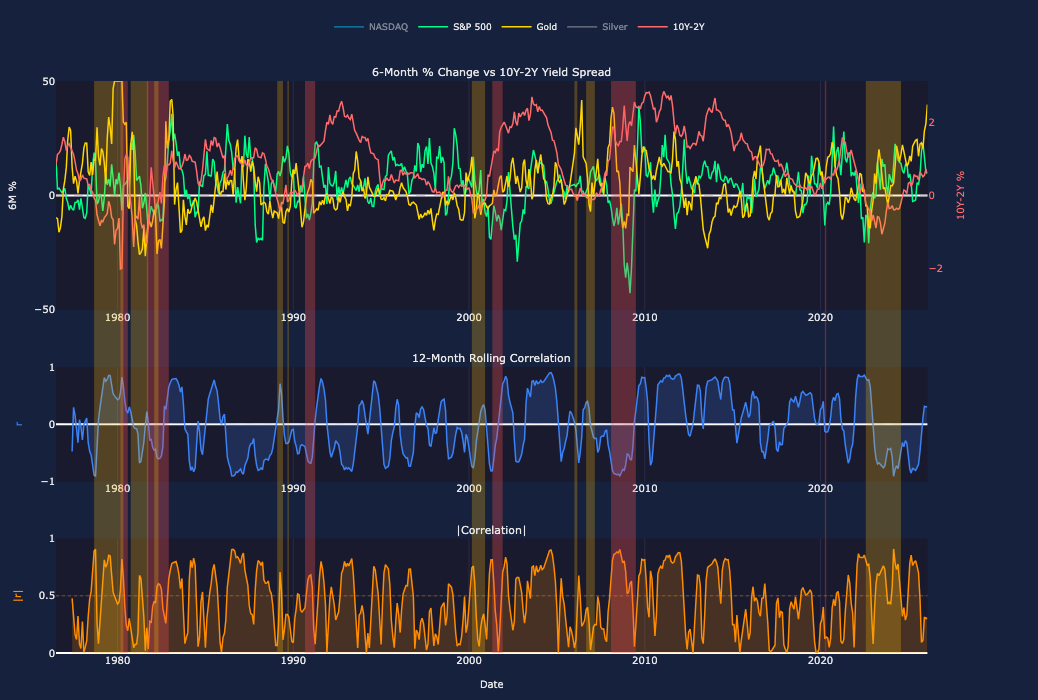

In [4]:
# Main visualization

from helpers import enable_unified_spikeline

COLORS = {
    'background': '#1a1a2e',
    'paper': '#16213e',
    'grid': '#2a2a4a',
    'text': '#e8e8e8',
    'nasdaq': '#00d4ff',
    'sp500': '#00ff88',
    'gold': '#ffd700',
    'silver': '#b8b8b8',
    'spread': '#ff6b6b',
    'correlation': '#3b82f6',
    'abs_corr': '#ff8c00',
    'recession': 'rgba(255, 82, 82, 0.3)',
    'inversion': 'rgba(255, 193, 7, 0.25)',
    'zero_line': 'rgba(255, 255, 255, 0.3)',
    'spike': 'rgba(255, 255, 255, 0.5)',
}

LINE_WIDTH = 1.5
PCT_RANGE = 50
ROLLING_WINDOW = 12
NUM_ROWS = 3

# Asset configurations: (name, column, color_key, visible_by_default)
ASSETS = [
    ('NASDAQ', 'NASDAQ 6M %', 'nasdaq', False),
    ('S&P 500', 'S&P 500 6M %', 'sp500', True),
    ('Gold', 'Gold 6M %', 'gold', True),
    ('Silver', 'Silver 6M %', 'silver', False),
]


def add_period_shading(fig, periods, color, num_rows=3):
    """Add rectangular shading for time periods spanning all subplots."""
    # Use xref for the bottom x-axis (where all traces are bound for spike lines)
    # Use layer="above" because layer="below" gets covered by plot_bgcolor on some subplots
    xref = f"x{num_rows}"
    for start, end in periods:
        fig.add_shape(
            type="rect", x0=start, x1=end, y0=0, y1=1,
            xref=xref, yref="paper", fillcolor=color, line_width=0, layer="above"
        )


def add_asset_trace(fig, data, col, name, color, visible):
    """Add an asset trace to row 1 of the figure."""
    clipped_col = f'{col} clipped'
    asset_data = data[data[col].notna()]
    fig.add_trace(
        go.Scatter(
            x=asset_data.index,
            y=asset_data[clipped_col],
            name=name,
            line=dict(color=color, width=LINE_WIDTH),
            customdata=asset_data[col],
            hovertemplate=f'{name}: %{{customdata:.1f}}%<extra></extra>',
            visible=True if visible else 'legendonly'
        ),
        row=1, col=1, secondary_y=False
    )


def plot_chart():
    """Plot economic correlation chart with 3 subplots."""
    # Prepare data
    cols = ['NASDAQ 6M %', 'S&P 500 6M %', 'Yield Spread', 'Gold 6M %', 'Silver 6M %', 'Recession']
    plot_data = combined[cols].dropna(subset=['NASDAQ 6M %', 'Yield Spread']).copy()

    # Clip asset columns to axis range
    for _, col, _, _ in ASSETS:
        plot_data[f'{col} clipped'] = plot_data[col].clip(-PCT_RANGE, PCT_RANGE)

    spread_range = max(abs(plot_data['Yield Spread'].min()), plot_data['Yield Spread'].max()) * 1.1
    date_range = [plot_data.index.min(), plot_data.index.max()]

    # Create subplots (shared_xaxes=False so we can show tick labels on all rows)
    fig = make_subplots(
        rows=NUM_ROWS, cols=1,
        row_heights=[0.50, 0.25, 0.25],
        shared_xaxes=False,
        vertical_spacing=0.1,
        specs=[[{"secondary_y": True}], [{"secondary_y": False}], [{"secondary_y": False}]],
        subplot_titles=('6-Month % Change vs 10Y-2Y Yield Spread', '12-Month Rolling Correlation', '|Correlation|')
    )

    # Add period shading (use xref=x3 since all traces are bound to x3 for spike lines)
    add_period_shading(fig, recession_periods, COLORS['recession'], NUM_ROWS)
    add_period_shading(fig, get_inversion_periods(plot_data), COLORS['inversion'], NUM_ROWS)

    # Row 1: Asset traces
    for name, col, color_key, visible in ASSETS:
        add_asset_trace(fig, plot_data, col, name, COLORS[color_key], visible)

    # Row 1: Yield spread (secondary y-axis)
    fig.add_trace(
        go.Scatter(
            x=plot_data.index, y=plot_data['Yield Spread'], name='10Y-2Y',
            line=dict(color=COLORS['spread'], width=LINE_WIDTH),
            hovertemplate='10Y-2Y Spread: %{y:.2f}%<extra></extra>'
        ),
        row=1, col=1, secondary_y=True
    )

    # Row 1: Zero lines
    fig.add_hline(y=0, line_dash="dash", line_color=COLORS['zero_line'], line_width=1, row=1, col=1, secondary_y=False)
    fig.add_hline(y=0, line_dash="dash", line_color=COLORS['spread'], opacity=0.5, line_width=1, row=1, col=1, secondary_y=True)

    # Rolling correlation
    rolling_corr = plot_data['NASDAQ 6M %'].rolling(ROLLING_WINDOW).corr(plot_data['Yield Spread'])

    # Row 2: Correlation
    fig.add_trace(
        go.Scatter(
            x=rolling_corr.index, y=rolling_corr.values, name='r',
            line=dict(color=COLORS['correlation'], width=LINE_WIDTH),
            fill='tozeroy', fillcolor='rgba(59, 130, 246, 0.2)',
            hovertemplate='r: %{y:.2f}<extra></extra>', showlegend=False
        ),
        row=2, col=1
    )
    fig.add_hline(y=0, line_dash="dash", line_color=COLORS['zero_line'], line_width=1, row=2, col=1)

    # Row 3: Absolute correlation
    fig.add_trace(
        go.Scatter(
            x=rolling_corr.index, y=rolling_corr.abs().values, name='|r|',
            line=dict(color=COLORS['abs_corr'], width=LINE_WIDTH),
            fill='tozeroy', fillcolor='rgba(255, 140, 0, 0.2)',
            hovertemplate='|r|: %{y:.2f}<extra></extra>', showlegend=False
        ),
        row=3, col=1
    )
    fig.add_hline(y=0.5, line_dash="dot", line_color=COLORS['abs_corr'], opacity=0.4, line_width=1, row=3, col=1)

    # Enable unified spike line across all subplots
    enable_unified_spikeline(fig, NUM_ROWS, date_range, COLORS['spike'])

    # Subplot title styling
    for annotation in fig['layout']['annotations']:
        annotation['font'] = dict(size=11, color=COLORS['text'])

    # Layout
    fig.update_layout(
        height=700,
        hovermode='x unified',
        paper_bgcolor=COLORS['paper'],
        plot_bgcolor=COLORS['background'],
        font=dict(color=COLORS['text'], size=10),
        legend=dict(
            orientation='h', yanchor='top', y=1.12, xanchor='center', x=0.5,
            font=dict(size=9, color=COLORS['text']), bgcolor='rgba(0,0,0,0)'
        ),
        margin=dict(t=70, l=55, r=55, b=35),
        hoverlabel=dict(bgcolor=COLORS['paper'], font_size=11, font_color=COLORS['text']),
        spikedistance=-1,
    )

    # Y-axes
    yaxis_base = dict(gridcolor=COLORS['grid'], automargin=True, color=COLORS['text'])
    fig.update_yaxes(title_text='6M %', title_font=dict(size=10, color=COLORS['text']),
                     range=[-PCT_RANGE, PCT_RANGE], zeroline=False, tickvals=[-50, 0, 50],
                     row=1, col=1, secondary_y=False, **yaxis_base)
    fig.update_yaxes(title_text='10Y-2Y %', title_font=dict(size=10, color=COLORS['spread']),
                     range=[-spread_range, spread_range], nticks=5, color=COLORS['spread'],
                     gridcolor='rgba(0,0,0,0)', automargin=True,
                     row=1, col=1, secondary_y=True)
    fig.update_yaxes(title_text='r', title_font=dict(size=10, color=COLORS['correlation']),
                     range=[-1, 1], tickvals=[-1, 0, 1], row=2, col=1, **yaxis_base)
    fig.update_yaxes(title_text='|r|', title_font=dict(size=10, color=COLORS['abs_corr']),
                     range=[0, 1], tickvals=[0, 0.5, 1], row=3, col=1, **yaxis_base)

    # X-axes (show dates on all subplots)
    xaxis_base = dict(
        range=date_range,
        nticks=6, tickformat="%Y", tickangle=0, showticklabels=True,
        hoverformat='%b %Y', automargin=True, gridcolor=COLORS['grid'], color=COLORS['text'],
    )
    for row in range(1, NUM_ROWS + 1):
        extra = dict(title_text='Date', title_font=dict(size=10, color=COLORS['text'])) if row == NUM_ROWS else {}
        fig.update_xaxes(row=row, col=1, **xaxis_base, **extra)

    fig.show()


plot_chart()

In [5]:
# Summary statistics for all data
print("Summary Statistics")
print("=" * 70)
summary = pd.DataFrame({
    'NASDAQ 6M %': combined['NASDAQ 6M %'].describe(),
    'S&P 500 6M %': combined['S&P 500 6M %'].describe(),
    'Gold 6M %': combined['Gold 6M %'].describe(),
    'Silver 6M %': combined['Silver 6M %'].describe(),
    '10Y-2Y Spread': combined['Yield Spread'].describe()
}).round(2)
print(summary.to_string())

# Correlation matrix
print("\n" + "=" * 70)
print("Correlation Matrix")
print("=" * 70)
corr_cols = ['NASDAQ 6M %', 'S&P 500 6M %', 'Gold 6M %', 'Silver 6M %', 'Yield Spread']
corr_matrix = combined[corr_cols].corr().round(3)
print(corr_matrix.to_string())

Summary Statistics
       NASDAQ 6M %  S&P 500 6M %  Gold 6M %  Silver 6M %  10Y-2Y Spread
count       596.00        596.00     596.00       596.00         596.00
mean          6.97          4.91       4.39         5.49           0.85
std          15.68         10.60      14.49        29.36           0.91
min         -49.90        -42.70     -26.61       -58.01          -2.01
25%          -1.50         -1.26      -4.51        -8.50           0.19
50%           7.27          5.09       2.06         0.81           0.79
75%          14.84         11.47      11.09        12.93           1.48
max          71.45         38.84     129.12       329.35           2.84

Correlation Matrix
              NASDAQ 6M %  S&P 500 6M %  Gold 6M %  Silver 6M %  Yield Spread
NASDAQ 6M %         1.000         0.857      0.082        0.206        -0.039
S&P 500 6M %        0.857         1.000      0.033        0.227        -0.057
Gold 6M %           0.082         0.033      1.000        0.806        -0.105
S